In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import timeit 

In [16]:
df = pd.read_csv('Clean.csv')

In [17]:
df = df.drop('Unnamed: 0', axis=1)
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

X = X.drop(['is_ip_blacklisted','is_email_blacklisted'], axis=1)

In [18]:
#model = LogisticRegression(class_weight='balanced')
#model = RandomForestClassifier(n_estimators=100)
model = SVC(class_weight='balanced')
splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

In [19]:
x = StandardScaler().fit_transform(X)

pca = PCA(n_components=60)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_.sum()

X = principalDf

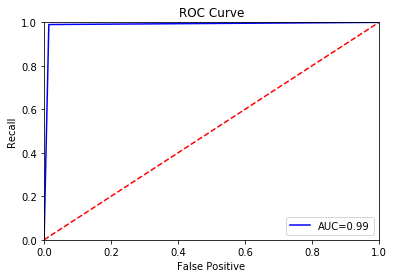

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     19000
          1       0.79      0.99      0.88      1000

avg / total       0.99      0.99      0.99     20000

[[18730   270]
 [   10   990]]


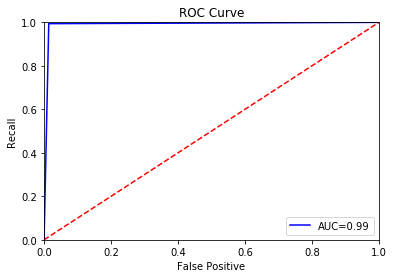

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     19000
          1       0.79      0.99      0.88      1000

avg / total       0.99      0.99      0.99     20000

[[18734   266]
 [    6   994]]


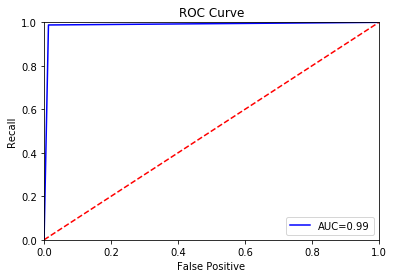

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     19000
          1       0.80      0.99      0.88      1000

avg / total       0.99      0.99      0.99     20000

[[18751   249]
 [   12   988]]


In [20]:
#%%timeit
#X = StandardScaler().fit_transform(X)


#X = X['age_of_account'].to_frame()

for train_indices, test_indices in splitter.split(X, y):
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
#     X_train = StandardScaler().fit_transform(X_train)
#     X_test = StandardScaler().fit_transform(X_test)
    
    clf = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = model.decision_function(X_test)
    
    fpr, recall, th = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, recall)
    plt.title('ROC Curve')
    plt.plot(fpr,recall, 'b', label='AUC=%0.2f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('False Positive')
    plt.show()
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

### Calculate FDP

In [24]:
ot = df.iloc[y_test.index]['order_total']
df2 = pd.concat([ot, y_test], axis=1)
df2 = df2.reset_index(drop=True)

In [25]:
p = pd.Series(y_pred_prob)
p2 = pd.Series(y_pred)

In [26]:
df3 = pd.concat([df2, p,p2], axis=1)

In [27]:
df3.rename(columns = {'is_fraud':'y_true', 0:'fraud_likelihood',1:'y_pred'}, inplace=True)
df3['dollar_scaled_likelihood'] = df3['fraud_likelihood'] * df3['order_total']
df3.head()

,order_total,y_true,fraud_likelihood,y_pred,dollar_scaled_likelihood
0,750.35,0,-1.984263,0,-1488.891399
1,98.99,0,-1.328749,0,-131.532837
2,503.48,0,-2.032423,0,-1023.284147
3,127.94,0,-2.559198,0,-327.423799
4,433.52,0,-3.193725,0,-1384.543868


In [28]:
# df3_fraud_dollars = df3.query('y_true==1')
# print('Total fraud dollars in the test set:', df3_fraud_dollars['order_total'].sum())

In [29]:
# cutoff=df3['dollar_scaled_likelihood'].quantile(0.95)
# cutoff2=df3['fraud_likelihood'].quantile(0.95)

In [30]:
# df3_fraud_dollars_pred = df3.loc[(df3['fraud_likelihood']>=cutoff2) & (df3['y_true']==1),'order_total']
# print('Total fraud dollars in the predicted set:', df3_fraud_dollars_pred.sum())

In [31]:
# print('Fraud dollar percentage:', df3_fraud_dollars_pred.sum()/ df3_fraud_dollars['order_total'].sum())

In [32]:
#X.boxplot(column='order_total', return_type='axes')

In [33]:
#X.groupby(['order_total'], as_index=False).count()

In [34]:
# X['is_duplicated'] = X.duplicated()
# X_dup = X.query('is_duplicated == True')
# X_dup

In [39]:
df3_fraud_dollars = df3.query('y_true==1')
df3_pred_fraud=df3.query('y_pred==1')
print('Total fraud dollars in the test set:', df3_fraud_dollars['order_total'].sum())

cutoff=df3['dollar_scaled_likelihood'].quantile(0.95)
cutoff2=df3['fraud_likelihood'].quantile(0.95)
# df3.loc[df3['fraud_likelihood']==True,'order_total']
# df3['fraud_likelihood'].value_counts()
x=df3_pred_fraud.sort_values(by='order_total',ascending=False)
x=x.iloc[:1000,]
# x

# df3_fraud_dollars_pred = df3.loc[(df3['dollar_scaled_likelihood']>=cutoff) & (df3['y_true']==1),'order_total']
df3_fraud_dollars_pred = x.loc[(x['y_true']==1),'order_total']
#df3_fraud_dollars_pred = x.query('y_true == 1')
print('Total fraud dollars in the predicted set:', df3_fraud_dollars_pred.sum())

print('Fraud dollar percentage:', df3_fraud_dollars_pred.sum()/ df3_fraud_dollars['order_total'].sum())

Total fraud dollars in the test set: 686599.4748
Total fraud dollars in the predicted set: 673104.9648
Fraud dollar percentage: 0.9803458777711258
